In [1]:
import joblib

#joblib.parallel_backend("threading")

In [2]:
"""
%cd /kaggle/working
#!git clone https://github.com/R-N/ml-utility-loss
%cd ml-utility-loss
!git pull
#!pip install .
!pip install . --no-deps --force-reinstall --upgrade
#"""

'\n%cd /kaggle/working\n#!git clone https://github.com/R-N/ml-utility-loss\n%cd ml-utility-loss\n!git pull\n#!pip install .\n!pip install . --no-deps --force-reinstall --upgrade\n#'

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]

In [4]:
datasets = [
    "insurance",
    "treatment",
    "contraceptive"
]

study_dir = "./"

In [5]:
#Parameters
import os

path_prefix = "../../../../"

dataset_dir = os.path.join(path_prefix, "ml-utility-loss/datasets")
dataset_name = "treatment"
model_name="ml_utility_2"
models = ["tvae", "realtabformer", "lct_gan", "tab_ddpm_concat"]
single_model = "lct_gan"
random_seed = 42
gp = True
gp_multiply = True
folder = "eval"
debug = False
path = None
param_index = 0
allow_same_prediction = True
log_wandb = False

In [6]:
# Parameters
dataset = "insurance"
dataset_name = "insurance"
single_model = "tab_ddpm_concat"
gp = False
gp_multiply = False
random_seed = 4
debug = False
folder = "eval"
path_prefix = "../../../../"
path = "eval/insurance/tab_ddpm_concat/4"
param_index = 3
allow_same_prediction = True
log_wandb = False


In [7]:
from pathlib import Path
import os

%cd /kaggle/working/

if path is None:
    path = os.path.join(folder, dataset_name, single_model, random_seed)
Path(path).mkdir(parents=True, exist_ok=True)

%cd {path}

/kaggle/working
/kaggle/working/eval/insurance/tab_ddpm_concat/4


In [8]:
from ml_utility_loss.util import seed
if single_model:
    model_name=f"{model_name}_{single_model}"
if random_seed is not None:
    seed(random_seed)
    print("Set seed to", seed)

Set seed to <function seed at 0x782422ce2320>


In [9]:
import pandas as pd
import numpy as np
import json
import os

df = pd.read_csv(os.path.join(dataset_dir, f"{dataset_name}.csv"))
with open(os.path.join(dataset_dir, f"{dataset_name}.json")) as f:
    info = json.load(f)

In [10]:
task = info["task"]
target = info["target"]
cat_features = info["cat_features"]
mixed_features = info["mixed_features"]
longtail_features = info["longtail_features"]
integer_features = info["integer_features"]

test = df.sample(frac=0.2, random_state=42)
train = df[~df.index.isin(test.index)]

In [11]:
import ml_utility_loss.synthesizers.tab_ddpm.params as TAB_DDPM_PARAMS
import ml_utility_loss.synthesizers.lct_gan.params as LCT_GAN_PARAMS
import ml_utility_loss.synthesizers.realtabformer.params as RTF_PARAMS
from ml_utility_loss.synthesizers.realtabformer.params.default import GPT2_PARAMS, REALTABFORMER_PARAMS
from ml_utility_loss.util import filter_dict_2, filter_dict

tab_ddpm_params = getattr(TAB_DDPM_PARAMS, dataset_name).BEST
lct_gan_params = getattr(LCT_GAN_PARAMS, dataset_name).BEST
lct_ae_params = filter_dict_2(lct_gan_params, LCT_GAN_PARAMS.default.AE_PARAMS)
rtf_params = getattr(RTF_PARAMS, dataset_name).BEST
rtf_params = filter_dict(rtf_params, REALTABFORMER_PARAMS)

lct_ae_embedding_size=lct_gan_params["embedding_size"]
tab_ddpm_normalization="quantile"
tab_ddpm_cat_encoding=tab_ddpm_params["cat_encoding"]
#tab_ddpm_cat_encoding="one-hot"
tab_ddpm_y_policy="default"
tab_ddpm_is_y_cond=True

In [12]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_lct_ae

lct_ae = load_lct_ae(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="lct_ae",
    df_name="df",
)
lct_ae = None

2024-03-03 11:01:49.494405: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 11:01:49.494461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 11:01:49.496116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_rtf_embed

rtf_embed = load_rtf_embed(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="realtabformer",
    df_name="df",
    ckpt_type="best-disc-model"
)

In [14]:
from ml_utility_loss.loss_learning.estimator.preprocessing import DataPreprocessor

preprocessor = DataPreprocessor(
    task,
    target=target,
    cat_features=cat_features,
    mixed_features=mixed_features,
    longtail_features=longtail_features,
    integer_features=integer_features,
    lct_ae_embedding_size=lct_ae_embedding_size,
    lct_ae_params=lct_ae_params,
    lct_ae=lct_ae,
    tab_ddpm_normalization=tab_ddpm_normalization,
    tab_ddpm_cat_encoding=tab_ddpm_cat_encoding,
    tab_ddpm_y_policy=tab_ddpm_y_policy,
    tab_ddpm_is_y_cond=tab_ddpm_is_y_cond,
    realtabformer_embedding=rtf_embed,
    realtabformer_params=rtf_params,
)
preprocessor.fit(df)

/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
preprocessor.adapter_sizes

{'tvae': 36,
 'realtabformer': (19, 551, Embedding(551, 800), True),
 'lct_gan': 29,
 'tab_ddpm_concat': 12}

In [16]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset_3_factory

datasetsn = load_dataset_3_factory(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/"),
    dataset_name=dataset_name,
    preprocessor=preprocessor,
    cache_dir=path_prefix,
)


In [17]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset

test_set = load_dataset(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/", "datasets_5", dataset_name),
    preprocessor=preprocessor,
    cache_dir=os.path.join(path_prefix, dataset_name, "_cache_test"),
    start=200,
    #stop=600,
    val=False,
    ratio=0,
    drop_first_column=True,
    model=single_model,
)

Caching in ../../../../insurance/_cache_test/tab_ddpm_concat/all inf False


In [18]:
import ml_utility_loss.loss_learning.estimator.params2 as PARAMS
from ml_utility_loss.tuning import map_parameters
from ml_utility_loss.loss_learning.estimator.params.default import update_param_space, update_param_space_2
import wandb

#"""
param_space = {
    **getattr(PARAMS, dataset_name).PARAM_SPACE,
}
params = {
    **getattr(PARAMS, dataset_name).BESTS[param_index],
}
if gp:
    params["gradient_penalty_mode"] = "ALL"
    params["mse_mag"] = True
    if gp_multiply:
        params["mse_mag_multiply"] = True
        params["mse_mag_target"] = 1.0
    else:
        params["mse_mag_multiply"] = False
        params["mse_mag_target"] = 0.1
else:
    params["gradient_penalty_mode"] = "NONE"
    params["mse_mag"] = False
params["single_model"] = False
if models:
    params["models"] = models
if single_model:
    params["fixed_role_model"] = single_model
    params["single_model"] = True
    params["models"] = [single_model]
if params["fixed_role_model"] == "realtabformer" and dataset_name == "treatment":
    params["batch_size"] = 2
params["max_seconds"] = 3600
params["patience"] = 10
params["epochs"] = 100
if debug:
    params["epochs"] = 2
with open("params.json", "w") as f:
    json.dump(params, f)
params = map_parameters(params, param_space=param_space)
params

{'loss_balancer_beta': 0.7520229775744602,
 'loss_balancer_r': 0.9706519501751338,
 'tf_pma_low': 64,
 'grad_loss_fn': <function torch.nn.functional.l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>,
 'pma_ffn_mode': 'shared',
 'patience': 10,
 'inds_init_mode': 'fixnorm',
 'grad_clip': 0.6896836352825375,
 'head_final_mul': 'identity',
 'gradient_penalty_mode': {'gradient_penalty': False,
  'calc_grad_m': False,
  'avg_non_role_model_m': False,
  'inverse_avg_non_role_model_m': False},
 'dataset_size': 2048,
 'batch_size': 4,
 'epochs': 100,
 'lr_mul': 0.08030439779404704,
 'n_warmup_steps': 85,
 'Optim': torch_optimizer.diffgrad.DiffGrad,
 'fixed_role_model': 'tab_ddpm_concat',
 'd_model': 256,
 'attn_activation': torch.nn.modules.activation.Sigmoid,
 'tf_d_inner': 256,
 'tf_n_layers_enc': 5,
 'tf_n_head': 128,
 'tf_activation': ml_utility_loss.activations.LeakyHardsigmoid,


In [19]:
train_set, val_set = datasetsn(model=params["fixed_role_model"], synth_data=params["synth_data"])

load_dataset_3_factory 2
Caching in ../../../../insurance/_cache/tab_ddpm_concat/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_2/insurance [80, 20]
Caching in ../../../../insurance/_cache4/tab_ddpm_concat/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_4/insurance [80, 20]
Caching in ../../../../insurance/_cache5/tab_ddpm_concat/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_5/insurance [160, 40]
[320, 80]
[320, 80]


In [20]:
from ml_utility_loss.loss_learning.estimator.model.pipeline import remove_non_model_params
from ml_utility_loss.loss_learning.estimator.pipeline import create_model
from ml_utility_loss.util import filter_dict, clear_memory

clear_memory()

params2 = remove_non_model_params(params)
adapters = filter_dict(preprocessor.adapter_sizes, params["models"])

model = create_model(
    adapters=adapters,
    #Body="twin_encoder",
    **params2,
)
#cf.apply_weight_standardization(model, n_last_layers_ignore=0)
print(model.models, len(model.adapters))

Creating model of type <class 'ml_utility_loss.loss_learning.estimator.model.models.TwinEncoder'>


[*] Embedding False True
['tab_ddpm_concat'] 1


In [21]:
study_name=f"{model_name}_{dataset_name}"

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

8696065

In [23]:
from torchinfo import summary

role_model = params["fixed_role_model"]
s = train_set[0][role_model]
summary(model[role_model], input_size=((2, *s[0].shape), (2, *s[1].shape)), depth=9) # 8 max

Layer (type:depth-idx)                                                 Output Shape              Param #
MLUtilitySingle                                                        [2, 1071, 12]             --
├─Adapter: 1-1                                                         [2, 1071, 12]             --
│    └─Sequential: 2-1                                                 [2, 1071, 256]            --
│    │    └─FeedForward: 3-1                                           [2, 1071, 256]            --
│    │    │    └─Linear: 4-1                                           [2, 1071, 256]            3,328
│    │    │    └─ReLU6: 4-2                                            [2, 1071, 256]            --
│    │    └─FeedForward: 3-2                                           [2, 1071, 256]            --
│    │    │    └─Linear: 4-3                                           [2, 1071, 256]            65,792
│    │    │    └─ReLU6: 4-4                                            [2, 1071, 256]   

In [24]:
import torch
from ml_utility_loss.loss_learning.estimator.pipeline import train, train_2
from ml_utility_loss.loss_learning.estimator.process_simple import train_epoch, eval as _eval
from ml_utility_loss.params import GradientPenaltyMode
from ml_utility_loss.util import clear_memory
import time
#torch.autograd.set_detect_anomaly(True)

clear_memory()

opt = params["Optim"](model.parameters())
loss = train_2(
    [train_set, val_set, test_set],
    preprocessor=preprocessor,
    whole_model=model,
    optim=opt,
    log_dir="logs",
    checkpoint_dir="checkpoints",
    verbose=True,
    allow_same_prediction=allow_same_prediction,
    wandb=wandb if log_wandb else None,
    study_name=study_name,
    **params
)

g_loss_mul 0.1
Epoch 0


Train loss {'avg_role_model_loss': 0.11390677978924942, 'avg_role_model_std_loss': 1.6075929376992917, 'avg_role_model_mean_pred_loss': 0.05657142685045635, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.11390677978924942, 'n_size': 320, 'n_batch': 80, 'duration': 84.47398400306702, 'duration_batch': 1.0559248000383377, 'duration_size': 0.2639812000095844, 'avg_pred_std': 0.09700191575684584}


Val loss {'avg_role_model_loss': 0.016991531396342907, 'avg_role_model_std_loss': 16.768777330477747, 'avg_role_model_mean_pred_loss': 0.0011311913316453647, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.016991531396342907, 'n_size': 80, 'n_batch': 20, 'duration': 17.97755455970764, 'duration_batch': 0.8988777279853821, 'duration_size': 0.22471943199634553, 'avg_pred_std': 0.016752634930890055}
Epoch 1


Train loss {'avg_role_model_loss': 0.02035002698939934, 'avg_role_model_std_loss': 3.3028829722441513, 'avg_role_model_mean_pred_loss': 0.0012390867967089977, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.02035002698939934, 'n_size': 320, 'n_batch': 80, 'duration': 84.68451976776123, 'duration_batch': 1.0585564970970154, 'duration_size': 0.26463912427425385, 'avg_pred_std': 0.06200033854111098}


Val loss {'avg_role_model_loss': 0.011681753185985144, 'avg_role_model_std_loss': 4.98499947126902, 'avg_role_model_mean_pred_loss': 0.00011886494331716512, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011681753185985144, 'n_size': 80, 'n_batch': 20, 'duration': 18.428929567337036, 'duration_batch': 0.9214464783668518, 'duration_size': 0.23036161959171295, 'avg_pred_std': 0.022514818981289864}
Epoch 2


Train loss {'avg_role_model_loss': 0.015553263086258085, 'avg_role_model_std_loss': 4.40048983076071, 'avg_role_model_mean_pred_loss': 0.0012610154882150097, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.015553263086258085, 'n_size': 320, 'n_batch': 80, 'duration': 84.47719740867615, 'duration_batch': 1.055964967608452, 'duration_size': 0.263991241902113, 'avg_pred_std': 0.04350193784048315}


Val loss {'avg_role_model_loss': 0.012001678717297182, 'avg_role_model_std_loss': 2.0838609129365295, 'avg_role_model_mean_pred_loss': 0.00018355202230315414, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.012001678717297182, 'n_size': 80, 'n_batch': 20, 'duration': 18.23084259033203, 'duration_batch': 0.9115421295166015, 'duration_size': 0.22788553237915038, 'avg_pred_std': 0.026969157496932895}
Epoch 3


Train loss {'avg_role_model_loss': 0.012385944992274744, 'avg_role_model_std_loss': 3.628137231519884, 'avg_role_model_mean_pred_loss': 0.0006446951736899908, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.012385944992274744, 'n_size': 320, 'n_batch': 80, 'duration': 84.30943512916565, 'duration_batch': 1.0538679391145707, 'duration_size': 0.26346698477864267, 'avg_pred_std': 0.03804389561410062}


Val loss {'avg_role_model_loss': 0.011361928719270508, 'avg_role_model_std_loss': 2.9160453390245267, 'avg_role_model_mean_pred_loss': 0.00016351417628470699, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011361928719270508, 'n_size': 80, 'n_batch': 20, 'duration': 18.110987901687622, 'duration_batch': 0.9055493950843811, 'duration_size': 0.2263873487710953, 'avg_pred_std': 0.02250743337208405}
Epoch 4


Train loss {'avg_role_model_loss': 0.012263958598123282, 'avg_role_model_std_loss': 3.76344175813676, 'avg_role_model_mean_pred_loss': 0.0004104777633484336, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.012263958598123282, 'n_size': 320, 'n_batch': 80, 'duration': 84.6977150440216, 'duration_batch': 1.05872143805027, 'duration_size': 0.2646803595125675, 'avg_pred_std': 0.03591603521199431}


Val loss {'avg_role_model_loss': 0.011301952104258817, 'avg_role_model_std_loss': 2.2325485425771605, 'avg_role_model_mean_pred_loss': 0.00016856359858614668, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011301952104258817, 'n_size': 80, 'n_batch': 20, 'duration': 18.113478422164917, 'duration_batch': 0.9056739211082458, 'duration_size': 0.22641848027706146, 'avg_pred_std': 0.028445655293762685}
Epoch 5


Train loss {'avg_role_model_loss': 0.011240640739742958, 'avg_role_model_std_loss': 2.6737590567842524, 'avg_role_model_mean_pred_loss': 0.00015413710455663006, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011240640739742958, 'n_size': 320, 'n_batch': 80, 'duration': 84.4088442325592, 'duration_batch': 1.05511055290699, 'duration_size': 0.2637776382267475, 'avg_pred_std': 0.04411998361465521}


Val loss {'avg_role_model_loss': 0.009927860215248075, 'avg_role_model_std_loss': 1.5344439736139974, 'avg_role_model_mean_pred_loss': 2.0057166005040678e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009927860215248075, 'n_size': 80, 'n_batch': 20, 'duration': 18.26319670677185, 'duration_batch': 0.9131598353385926, 'duration_size': 0.22828995883464814, 'avg_pred_std': 0.03175867693498731}
Epoch 6


Train loss {'avg_role_model_loss': 0.011858757758818683, 'avg_role_model_std_loss': 3.5301289926825974, 'avg_role_model_mean_pred_loss': 0.0002819792471252053, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011858757758818683, 'n_size': 320, 'n_batch': 80, 'duration': 84.27680397033691, 'duration_batch': 1.0534600496292115, 'duration_size': 0.26336501240730287, 'avg_pred_std': 0.03954663624172099}


Val loss {'avg_role_model_loss': 0.012078169028973207, 'avg_role_model_std_loss': 4.102863686283408, 'avg_role_model_mean_pred_loss': 0.000203830946862138, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.012078169028973207, 'n_size': 80, 'n_batch': 20, 'duration': 18.098918199539185, 'duration_batch': 0.9049459099769592, 'duration_size': 0.2262364774942398, 'avg_pred_std': 0.021373049879912287}
Epoch 7


Train loss {'avg_role_model_loss': 0.012539188255323097, 'avg_role_model_std_loss': 3.3092838149226282, 'avg_role_model_mean_pred_loss': 0.00023790401172929277, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.012539188255323097, 'n_size': 320, 'n_batch': 80, 'duration': 84.52259421348572, 'duration_batch': 1.0565324276685715, 'duration_size': 0.26413310691714287, 'avg_pred_std': 0.04043100443377625}


Val loss {'avg_role_model_loss': 0.009674683933417328, 'avg_role_model_std_loss': 0.9977919148524961, 'avg_role_model_mean_pred_loss': 1.1186481361031685e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009674683933417328, 'n_size': 80, 'n_batch': 20, 'duration': 18.143858671188354, 'duration_batch': 0.9071929335594178, 'duration_size': 0.22679823338985444, 'avg_pred_std': 0.04099587097298354}
Epoch 8


Train loss {'avg_role_model_loss': 0.011895681292844528, 'avg_role_model_std_loss': 2.8657706266691036, 'avg_role_model_mean_pred_loss': 0.0002743295693480711, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011895681292844528, 'n_size': 320, 'n_batch': 80, 'duration': 84.31953191757202, 'duration_batch': 1.0539941489696503, 'duration_size': 0.26349853724241257, 'avg_pred_std': 0.042222958011552694}


Val loss {'avg_role_model_loss': 0.009975977733847684, 'avg_role_model_std_loss': 1.1835033869873883, 'avg_role_model_mean_pred_loss': 2.0587880793299097e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009975977733847684, 'n_size': 80, 'n_batch': 20, 'duration': 18.042185306549072, 'duration_batch': 0.9021092653274536, 'duration_size': 0.2255273163318634, 'avg_pred_std': 0.035635373927652834}
Epoch 9


Train loss {'avg_role_model_loss': 0.010924837501352157, 'avg_role_model_std_loss': 2.593468050354761, 'avg_role_model_mean_pred_loss': 9.935248510884783e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010924837501352157, 'n_size': 320, 'n_batch': 80, 'duration': 84.26527738571167, 'duration_batch': 1.0533159673213959, 'duration_size': 0.26332899183034897, 'avg_pred_std': 0.045242260512895885}


Val loss {'avg_role_model_loss': 0.010778275438860873, 'avg_role_model_std_loss': 3.146427918606969, 'avg_role_model_mean_pred_loss': 7.896810024603518e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010778275438860873, 'n_size': 80, 'n_batch': 20, 'duration': 18.036173820495605, 'duration_batch': 0.9018086910247802, 'duration_size': 0.22545217275619506, 'avg_pred_std': 0.022399809048511087}
Epoch 10


Train loss {'avg_role_model_loss': 0.011383894624395907, 'avg_role_model_std_loss': 2.930524671732963, 'avg_role_model_mean_pred_loss': 0.00018457749493845378, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011383894624395907, 'n_size': 320, 'n_batch': 80, 'duration': 84.58404278755188, 'duration_batch': 1.0573005348443985, 'duration_size': 0.2643251337110996, 'avg_pred_std': 0.042266642485628836}


Val loss {'avg_role_model_loss': 0.009755220862280112, 'avg_role_model_std_loss': 1.5220770264881138, 'avg_role_model_mean_pred_loss': 1.059227741908586e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009755220862280112, 'n_size': 80, 'n_batch': 20, 'duration': 17.980788469314575, 'duration_batch': 0.8990394234657287, 'duration_size': 0.22475985586643218, 'avg_pred_std': 0.03333416555542499}
Epoch 11


Train loss {'avg_role_model_loss': 0.010721845665102592, 'avg_role_model_std_loss': 1.8063977722115752, 'avg_role_model_mean_pred_loss': 9.594455589044034e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010721845665102592, 'n_size': 320, 'n_batch': 80, 'duration': 84.16543889045715, 'duration_batch': 1.0520679861307145, 'duration_size': 0.2630169965326786, 'avg_pred_std': 0.047608432272681966}


Val loss {'avg_role_model_loss': 0.009559676682692952, 'avg_role_model_std_loss': 1.3243680567820775, 'avg_role_model_mean_pred_loss': 9.947778448005095e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009559676682692952, 'n_size': 80, 'n_batch': 20, 'duration': 18.158392667770386, 'duration_batch': 0.9079196333885193, 'duration_size': 0.22697990834712983, 'avg_pred_std': 0.031689733476378025}
Epoch 12


Train loss {'avg_role_model_loss': 0.011144705655783581, 'avg_role_model_std_loss': 2.4096494605510026, 'avg_role_model_mean_pred_loss': 0.00032173466922595813, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011144705655783581, 'n_size': 320, 'n_batch': 80, 'duration': 84.13634371757507, 'duration_batch': 1.0517042964696883, 'duration_size': 0.2629260741174221, 'avg_pred_std': 0.044573025617864914}


Val loss {'avg_role_model_loss': 0.009567469572357368, 'avg_role_model_std_loss': 1.5696021520542787, 'avg_role_model_mean_pred_loss': 1.1404201347278014e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009567469572357368, 'n_size': 80, 'n_batch': 20, 'duration': 17.92456030845642, 'duration_batch': 0.896228015422821, 'duration_size': 0.22405700385570526, 'avg_pred_std': 0.03133328107651323}
Epoch 13


Train loss {'avg_role_model_loss': 0.010633787492497503, 'avg_role_model_std_loss': 2.5790517816062755, 'avg_role_model_mean_pred_loss': 0.0003470440018317923, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010633787492497503, 'n_size': 320, 'n_batch': 80, 'duration': 84.38668012619019, 'duration_batch': 1.0548335015773773, 'duration_size': 0.26370837539434433, 'avg_pred_std': 0.04384268364228774}


Val loss {'avg_role_model_loss': 0.009436554487911053, 'avg_role_model_std_loss': 1.4380358837069962, 'avg_role_model_mean_pred_loss': 1.7537142142520778e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009436554487911053, 'n_size': 80, 'n_batch': 20, 'duration': 18.151715517044067, 'duration_batch': 0.9075857758522033, 'duration_size': 0.22689644396305084, 'avg_pred_std': 0.03785984092392027}
Epoch 14


Train loss {'avg_role_model_loss': 0.01104943135223948, 'avg_role_model_std_loss': 2.1088742282857766, 'avg_role_model_mean_pred_loss': 0.0002007622467717723, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.01104943135223948, 'n_size': 320, 'n_batch': 80, 'duration': 84.27291560173035, 'duration_batch': 1.0534114450216294, 'duration_size': 0.26335286125540736, 'avg_pred_std': 0.0478535434929654}


Val loss {'avg_role_model_loss': 0.01036879940838844, 'avg_role_model_std_loss': 0.8904372502282059, 'avg_role_model_mean_pred_loss': 7.801706653562946e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.01036879940838844, 'n_size': 80, 'n_batch': 20, 'duration': 18.29806423187256, 'duration_batch': 0.914903211593628, 'duration_size': 0.228725802898407, 'avg_pred_std': 0.051562142791226506}
Epoch 15


Train loss {'avg_role_model_loss': 0.011128615495272243, 'avg_role_model_std_loss': 1.7709791813538458, 'avg_role_model_mean_pred_loss': 0.00021516576313122763, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011128615495272243, 'n_size': 320, 'n_batch': 80, 'duration': 85.58019542694092, 'duration_batch': 1.0697524428367615, 'duration_size': 0.2674381107091904, 'avg_pred_std': 0.049932096980046484}


Val loss {'avg_role_model_loss': 0.00949138020951068, 'avg_role_model_std_loss': 1.0204340409804673, 'avg_role_model_mean_pred_loss': 1.8300672786680795e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00949138020951068, 'n_size': 80, 'n_batch': 20, 'duration': 18.28961968421936, 'duration_batch': 0.914480984210968, 'duration_size': 0.228620246052742, 'avg_pred_std': 0.04147392325103283}
Epoch 16


Train loss {'avg_role_model_loss': 0.010429539207643756, 'avg_role_model_std_loss': 1.5362692275628125, 'avg_role_model_mean_pred_loss': 0.00025102296517166747, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010429539207643756, 'n_size': 320, 'n_batch': 80, 'duration': 84.87365674972534, 'duration_batch': 1.0609207093715667, 'duration_size': 0.26523017734289167, 'avg_pred_std': 0.05195366198895499}


Val loss {'avg_role_model_loss': 0.009322703200996329, 'avg_role_model_std_loss': 1.743853185043554, 'avg_role_model_mean_pred_loss': 1.2576797408925255e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009322703200996329, 'n_size': 80, 'n_batch': 20, 'duration': 17.977401971817017, 'duration_batch': 0.8988700985908509, 'duration_size': 0.22471752464771272, 'avg_pred_std': 0.03613527067936957}
Epoch 17


Train loss {'avg_role_model_loss': 0.010465346425053212, 'avg_role_model_std_loss': 1.4406497691373554, 'avg_role_model_mean_pred_loss': 0.00016243213518344694, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010465346425053212, 'n_size': 320, 'n_batch': 80, 'duration': 84.5495491027832, 'duration_batch': 1.0568693637847901, 'duration_size': 0.26421734094619753, 'avg_pred_std': 0.04888715610140935}


Val loss {'avg_role_model_loss': 0.009582025398412953, 'avg_role_model_std_loss': 3.081415921854597, 'avg_role_model_mean_pred_loss': 5.574405601427302e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009582025398412953, 'n_size': 80, 'n_batch': 20, 'duration': 17.912070274353027, 'duration_batch': 0.8956035137176513, 'duration_size': 0.22390087842941284, 'avg_pred_std': 0.025306159909814597}
Epoch 18


Train loss {'avg_role_model_loss': 0.010162418862455525, 'avg_role_model_std_loss': 1.5145359354102208, 'avg_role_model_mean_pred_loss': 6.209586736886912e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010162418862455525, 'n_size': 320, 'n_batch': 80, 'duration': 84.28248190879822, 'duration_batch': 1.0535310238599778, 'duration_size': 0.26338275596499444, 'avg_pred_std': 0.0519078379671555}


Val loss {'avg_role_model_loss': 0.009476123469903541, 'avg_role_model_std_loss': 1.0078544585018676, 'avg_role_model_mean_pred_loss': 1.8715846066100564e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009476123469903541, 'n_size': 80, 'n_batch': 20, 'duration': 17.901034355163574, 'duration_batch': 0.8950517177581787, 'duration_size': 0.22376292943954468, 'avg_pred_std': 0.03873717384412885}
Epoch 19


Train loss {'avg_role_model_loss': 0.010770342201794847, 'avg_role_model_std_loss': 2.009929773015307, 'avg_role_model_mean_pred_loss': 0.00013072784897420476, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010770342201794847, 'n_size': 320, 'n_batch': 80, 'duration': 84.82972049713135, 'duration_batch': 1.060371506214142, 'duration_size': 0.2650928765535355, 'avg_pred_std': 0.04557969000888988}


Val loss {'avg_role_model_loss': 0.009593866099567094, 'avg_role_model_std_loss': 0.7345563380621798, 'avg_role_model_mean_pred_loss': 1.3211068784391156e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009593866099567094, 'n_size': 80, 'n_batch': 20, 'duration': 18.183232307434082, 'duration_batch': 0.9091616153717041, 'duration_size': 0.22729040384292604, 'avg_pred_std': 0.04364799705799669}
Epoch 20


Train loss {'avg_role_model_loss': 0.011184974256775605, 'avg_role_model_std_loss': 1.735422194222258, 'avg_role_model_mean_pred_loss': 0.00015653051535653267, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011184974256775605, 'n_size': 320, 'n_batch': 80, 'duration': 84.4685800075531, 'duration_batch': 1.0558572500944137, 'duration_size': 0.2639643125236034, 'avg_pred_std': 0.04943769198143855}


Val loss {'avg_role_model_loss': 0.00922505634080153, 'avg_role_model_std_loss': 1.1232440773048438, 'avg_role_model_mean_pred_loss': 2.5773531761252856e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00922505634080153, 'n_size': 80, 'n_batch': 20, 'duration': 18.073370695114136, 'duration_batch': 0.9036685347557067, 'duration_size': 0.22591713368892669, 'avg_pred_std': 0.0375345426844433}
Epoch 21


Train loss {'avg_role_model_loss': 0.010670667553040403, 'avg_role_model_std_loss': 1.6657181285418345, 'avg_role_model_mean_pred_loss': 0.00026890914427888377, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010670667553040403, 'n_size': 320, 'n_batch': 80, 'duration': 84.49483013153076, 'duration_batch': 1.0561853766441345, 'duration_size': 0.2640463441610336, 'avg_pred_std': 0.0491774610709399}


Val loss {'avg_role_model_loss': 0.011584205193139496, 'avg_role_model_std_loss': 4.0657152492325626, 'avg_role_model_mean_pred_loss': 3.660291929232784e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011584205193139496, 'n_size': 80, 'n_batch': 20, 'duration': 17.99208927154541, 'duration_batch': 0.8996044635772705, 'duration_size': 0.22490111589431763, 'avg_pred_std': 0.030582628422416748}
Epoch 22


Train loss {'avg_role_model_loss': 0.011918405044889368, 'avg_role_model_std_loss': 1.9266218843145224, 'avg_role_model_mean_pred_loss': 0.000546820462109244, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011918405044889368, 'n_size': 320, 'n_batch': 80, 'duration': 84.82066988945007, 'duration_batch': 1.060258373618126, 'duration_size': 0.2650645934045315, 'avg_pred_std': 0.049488182202912866}


Val loss {'avg_role_model_loss': 0.009260490916494746, 'avg_role_model_std_loss': 2.0702868502448837, 'avg_role_model_mean_pred_loss': 1.115468241086326e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009260490916494746, 'n_size': 80, 'n_batch': 20, 'duration': 18.213539123535156, 'duration_batch': 0.9106769561767578, 'duration_size': 0.22766923904418945, 'avg_pred_std': 0.03006206527352333}
Epoch 23


Train loss {'avg_role_model_loss': 0.010364986025706457, 'avg_role_model_std_loss': 6.042574923066354, 'avg_role_model_mean_pred_loss': 0.00012542121491789134, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010364986025706457, 'n_size': 320, 'n_batch': 80, 'duration': 84.50646162033081, 'duration_batch': 1.0563307702541351, 'duration_size': 0.2640826925635338, 'avg_pred_std': 0.045613451191994156}


Val loss {'avg_role_model_loss': 0.009321882369113155, 'avg_role_model_std_loss': 1.242719502127511, 'avg_role_model_mean_pred_loss': 2.0408335805721654e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009321882369113155, 'n_size': 80, 'n_batch': 20, 'duration': 17.993885278701782, 'duration_batch': 0.8996942639350891, 'duration_size': 0.22492356598377228, 'avg_pred_std': 0.03894345450680703}
Epoch 24


Train loss {'avg_role_model_loss': 0.010127854481288523, 'avg_role_model_std_loss': 1.3548822252588457, 'avg_role_model_mean_pred_loss': 9.947211313221551e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010127854481288523, 'n_size': 320, 'n_batch': 80, 'duration': 84.6096601486206, 'duration_batch': 1.0576207518577576, 'duration_size': 0.2644051879644394, 'avg_pred_std': 0.05492281899787486}


Val loss {'avg_role_model_loss': 0.00973101281633717, 'avg_role_model_std_loss': 2.803459626334097, 'avg_role_model_mean_pred_loss': 3.2155193029839366e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00973101281633717, 'n_size': 80, 'n_batch': 20, 'duration': 18.34537410736084, 'duration_batch': 0.917268705368042, 'duration_size': 0.2293171763420105, 'avg_pred_std': 0.02301093057030812}
Epoch 25


Train loss {'avg_role_model_loss': 0.010673620513580317, 'avg_role_model_std_loss': 1.630422155917519, 'avg_role_model_mean_pred_loss': 0.0002799555220394656, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010673620513580317, 'n_size': 320, 'n_batch': 80, 'duration': 84.58660197257996, 'duration_batch': 1.0573325246572494, 'duration_size': 0.26433313116431234, 'avg_pred_std': 0.046520658489316705}


Val loss {'avg_role_model_loss': 0.009462428228289355, 'avg_role_model_std_loss': 2.6746044414641346, 'avg_role_model_mean_pred_loss': 1.355185217843946e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009462428228289355, 'n_size': 80, 'n_batch': 20, 'duration': 18.011495113372803, 'duration_batch': 0.9005747556686401, 'duration_size': 0.22514368891716002, 'avg_pred_std': 0.025657533458434044}
Epoch 26


Train loss {'avg_role_model_loss': 0.009991624747397055, 'avg_role_model_std_loss': 1.627927773291799, 'avg_role_model_mean_pred_loss': 8.125562307790029e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009991624747397055, 'n_size': 320, 'n_batch': 80, 'duration': 84.53830814361572, 'duration_batch': 1.0567288517951965, 'duration_size': 0.2641822129487991, 'avg_pred_std': 0.050572005746653305}


Val loss {'avg_role_model_loss': 0.01111485290057317, 'avg_role_model_std_loss': 2.272924814505939, 'avg_role_model_mean_pred_loss': 0.000244029233883869, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.01111485290057317, 'n_size': 80, 'n_batch': 20, 'duration': 18.182761192321777, 'duration_batch': 0.9091380596160888, 'duration_size': 0.2272845149040222, 'avg_pred_std': 0.02627429796848446}
Epoch 27


Train loss {'avg_role_model_loss': 0.011247798605666048, 'avg_role_model_std_loss': 2.117468389116715, 'avg_role_model_mean_pred_loss': 0.00020426704126478152, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.011247798605666048, 'n_size': 320, 'n_batch': 80, 'duration': 84.47703838348389, 'duration_batch': 1.0559629797935486, 'duration_size': 0.26399074494838715, 'avg_pred_std': 0.04596492229029536}


Val loss {'avg_role_model_loss': 0.009433183281817036, 'avg_role_model_std_loss': 1.450164285198241, 'avg_role_model_mean_pred_loss': 1.8529243547119787e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009433183281817036, 'n_size': 80, 'n_batch': 20, 'duration': 18.082876205444336, 'duration_batch': 0.9041438102722168, 'duration_size': 0.2260359525680542, 'avg_pred_std': 0.03382655227323994}
Epoch 28


Train loss {'avg_role_model_loss': 0.009869320008056093, 'avg_role_model_std_loss': 1.5068146906768447, 'avg_role_model_mean_pred_loss': 9.115362455692777e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009869320008056093, 'n_size': 320, 'n_batch': 80, 'duration': 84.38812756538391, 'duration_batch': 1.054851594567299, 'duration_size': 0.26371289864182473, 'avg_pred_std': 0.05035865947138518}


Val loss {'avg_role_model_loss': 0.009240709943878756, 'avg_role_model_std_loss': 1.3003549632573517, 'avg_role_model_mean_pred_loss': 6.990615373461684e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009240709943878756, 'n_size': 80, 'n_batch': 20, 'duration': 18.295058012008667, 'duration_batch': 0.9147529006004333, 'duration_size': 0.22868822515010834, 'avg_pred_std': 0.03447220445377752}
Epoch 29


Train loss {'avg_role_model_loss': 0.01015008869671874, 'avg_role_model_std_loss': 1.6426295430076934, 'avg_role_model_mean_pred_loss': 8.031235901584562e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.01015008869671874, 'n_size': 320, 'n_batch': 80, 'duration': 84.30770874023438, 'duration_batch': 1.0538463592529297, 'duration_size': 0.2634615898132324, 'avg_pred_std': 0.04944546818442177}


Val loss {'avg_role_model_loss': 0.008979192694823723, 'avg_role_model_std_loss': 1.013558323823196, 'avg_role_model_mean_pred_loss': 1.5330314378037e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.008979192694823723, 'n_size': 80, 'n_batch': 20, 'duration': 17.981907844543457, 'duration_batch': 0.8990953922271728, 'duration_size': 0.2247738480567932, 'avg_pred_std': 0.035569448093883696}
Epoch 30


Train loss {'avg_role_model_loss': 0.010348305049683404, 'avg_role_model_std_loss': 1.0208274961811328, 'avg_role_model_mean_pred_loss': 0.00023567322375602772, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010348305049683404, 'n_size': 320, 'n_batch': 80, 'duration': 84.40145015716553, 'duration_batch': 1.055018126964569, 'duration_size': 0.2637545317411423, 'avg_pred_std': 0.05335634221555665}


Val loss {'avg_role_model_loss': 0.009130275297502521, 'avg_role_model_std_loss': 1.2715821872590367, 'avg_role_model_mean_pred_loss': 7.716895467813068e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.009130275297502521, 'n_size': 80, 'n_batch': 20, 'duration': 18.11615824699402, 'duration_batch': 0.9058079123497009, 'duration_size': 0.22645197808742523, 'avg_pred_std': 0.03190355768892914}
Stopped False


Eval loss {'role_model': 'tab_ddpm_concat', 'n_size': 399, 'n_batch': 100, 'role_model_metrics': {'avg_loss': 0.019684911810006377, 'avg_g_mag_loss': nan, 'avg_g_cos_loss': 0.0021236211053054007, 'pred_duration': 2.178314447402954, 'grad_duration': 1.2552392482757568, 'total_duration': 3.433553695678711, 'pred_std': 0.06186112388968468, 'std_loss': 0.5796476006507874, 'mean_pred_loss': 4.718968921224587e-05, 'pred_rmse': 0.14030292630195618, 'pred_mae': 0.10000143945217133, 'pred_mape': 0.7038320302963257, 'grad_rmse': 0.2803622782230377, 'grad_mae': 0.19953711330890656, 'grad_mape': 0.9926933646202087}, 'non_role_model_metrics': {'avg_loss': 0, 'avg_g_mag_loss': 0, 'avg_g_cos_loss': 0, 'avg_pred_duration': 0, 'avg_grad_duration': 0, 'avg_total_duration': 0, 'avg_pred_std': 0, 'avg_std_loss': 0, 'avg_mean_pred_loss': 0}, 'avg_metrics': {'avg_loss': 0.019684911810006377, 'avg_g_mag_loss': nan, 'avg_g_cos_loss': 0.0021236211053054007, 'avg_pred_duration': 2.178314447402954, 'avg_grad_dur

In [25]:
model = loss["whole_model"]
opt = loss["optim"]

In [26]:
import torch
from copy import deepcopy

torch.save(deepcopy(model.state_dict()), "model.pt")
#torch.save(deepcopy(opt.state_dict()), "optim.pt")

<Axes: >

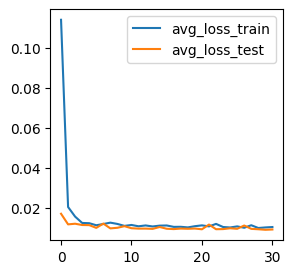

In [27]:
history = loss["history"]
history.to_csv("history.csv")
history[["avg_loss_train", "avg_loss_test"]].plot()

In [28]:

from ml_utility_loss.loss_learning.estimator.pipeline import eval
#eval_loss = loss["eval_loss"]

batch_size = params["batch_size_low"] if "batch_size_low" in params else params["batch_size"]

eval_loss = eval(
    test_set, model,
    batch_size=batch_size,
)

In [29]:
import pandas as pd

metrics = pd.DataFrame(eval_loss["model_metrics"]).T
metrics.to_csv("eval.csv")
metrics

avg_g_cos_loss  avg_g_mag_loss  avg_loss  grad_duration  \
tab_ddpm_concat        0.002556        0.524113  0.019685       1.261741   

                 grad_mae  grad_mape  grad_rmse  mean_pred_loss  \
tab_ddpm_concat  0.199537   0.992693   0.280362        0.000047   

                 pred_duration  pred_mae  pred_mape  pred_rmse  pred_std  \
tab_ddpm_concat       2.181129  0.100001   0.703832   0.140303  0.061861   

                 std_loss  total_duration  
tab_ddpm_concat  0.579648        3.442869

In [30]:
from ml_utility_loss.util import clear_memory
clear_memory()

In [31]:
#"""
from ml_utility_loss.loss_learning.estimator.process import pred, pred_2
from ml_utility_loss.util import stack_samples

#samples = test_set[list(range(len(test_set)))]
#y = {m: pred(model[m], s) for m, s in samples.items()}
y = pred_2(model, test_set, batch_size=batch_size)
#"""

Caching in ../../../../insurance/_cache_test/tab_ddpm_concat/all inf False


In [32]:
import os
import pandas as pd
from ml_utility_loss.util import transpose_dict

os.makedirs("pred", exist_ok=True)
y2 = transpose_dict(y)
for k, v in y2.items():
    df = pd.DataFrame(v)
    df.to_csv(f"pred/{k}.csv")

In [33]:
print({k: sum(v["pred"])/len(v["pred"]) for k, v in y.items()})

{'tab_ddpm_concat': 0.038165719780903475}


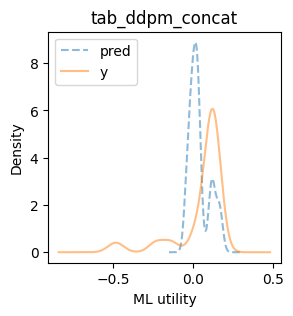

In [34]:
from ml_utility_loss.loss_learning.visualization import plot_pred_density_2

_ = plot_pred_density_2(y)

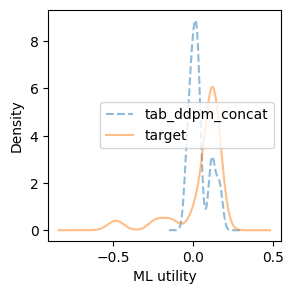

In [35]:
from ml_utility_loss.loss_learning.visualization import plot_density_3

_ = plot_density_3(y2["pred"], next(iter(y2["y"].values())))

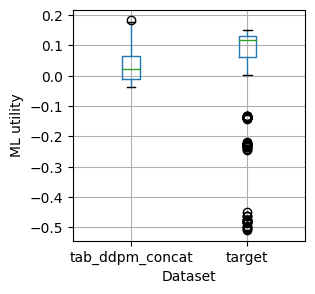

In [36]:
from ml_utility_loss.loss_learning.visualization import plot_box_3

_ = plot_box_3(y2["pred"], next(iter(y2["y"].values())))

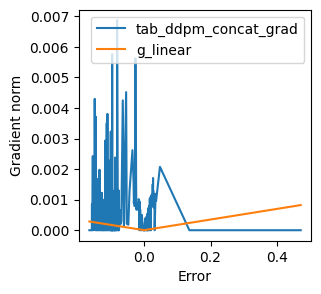

In [37]:
#"""
from ml_utility_loss.loss_learning.visualization import plot_grad, plot_grad_2, plot_grad_3
import matplotlib.pyplot as plt

#plot_grad_2(y, model.models)
for m in model.models:
    ym = y[m]
    fig, ax = plt.subplots()
    plot_grad_3(ym["error"], ym["grad"], name=f"{m}_grad", fig=fig, ax=ax)
#"""